### Import required libraries:::::

In [1090]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, classification_report
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

### Exploratory Data Analysis:::

In [1091]:
germanCreditData = pd.read_csv('./data/german_credit_data.csv')
germanCreditData.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [1092]:
germanCreditData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.3+ KB


In [1093]:
germanCreditData.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [1094]:
# Handling missing data for the categorical columns
germanCreditData = germanCreditData.fillna("Unknown")
germanCreditData.isnull().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

In [1095]:
# Seperating columns
catCols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Job', 'Risk']
numCols = ['Age', 'Credit amount', 'Duration']

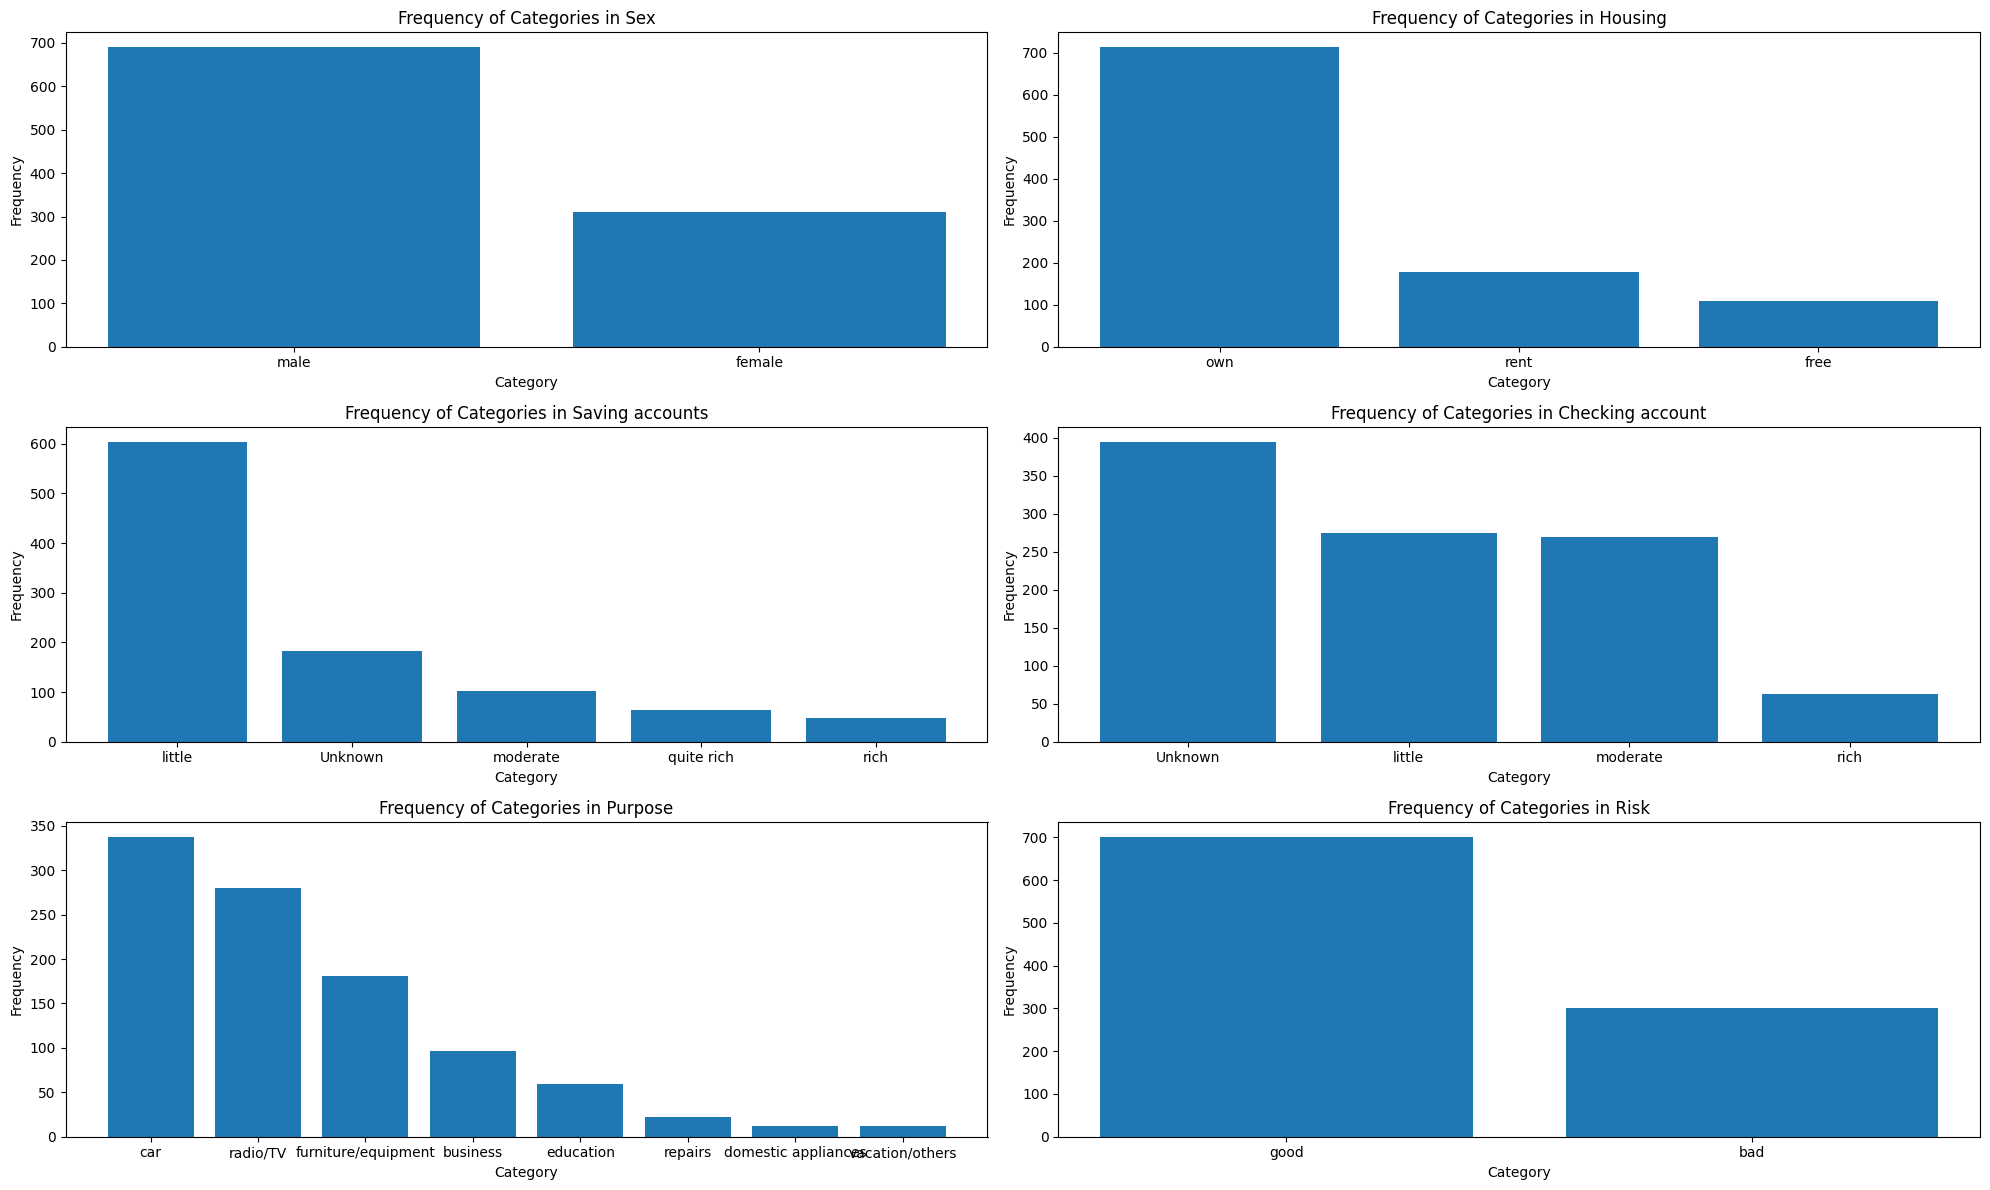

In [1096]:
germanCreditDataCatData = germanCreditData.drop(numCols + ['Job'], axis=1)
num_rows = (len(germanCreditDataCatData.columns) + 1) // 2
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))

axes = axes.flatten()

for i, col in enumerate(germanCreditDataCatData.columns):
    freq = germanCreditData[col].value_counts()
    axes[i].bar(freq.index, freq.values)
    axes[i].set_title(f'Frequency of Categories in {col}')
    axes[i].set_xlabel('Category')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()

plt.show()


- These are the plot of frequency of each categorical columns value. We can see which value has majority in the data. For example, the sex category has male more than two-fold than the female. Similarly, we can see the frequency for other categories.

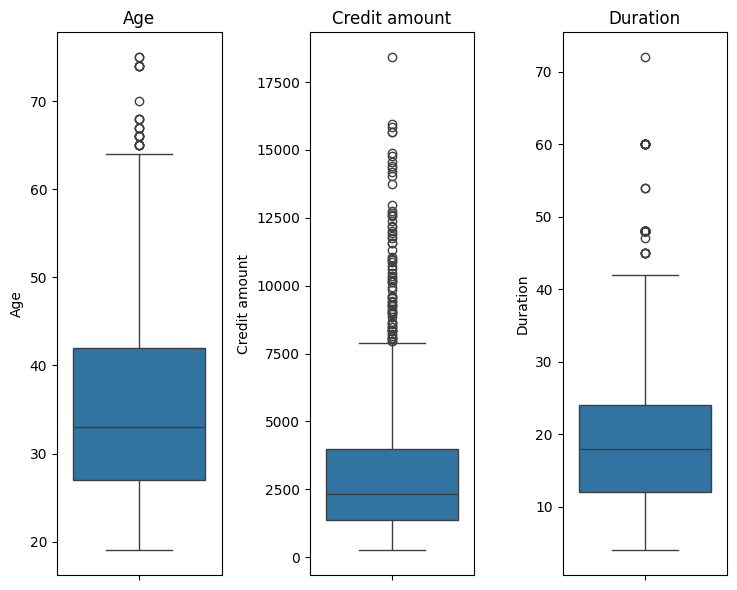

In [1097]:
plt.figure(figsize=(10, 6))
for index, column in enumerate(numCols, 1):
    plt.subplot(1, 4, index)
    sns.boxplot(y=germanCreditData[column])
    plt.title(column)
plt.tight_layout()
plt.show()

- The credit amount shows some outliers in it while other have negligible outliers.

In [1098]:
# Removing outliers using z-score.
for column in numCols:
    z_scores = stats.zscore(germanCreditData[column])
    threshold = 3
    outliers = germanCreditData[(z_scores > threshold) | (z_scores < -threshold)]
    mean = germanCreditData[column].mean()
    germanCreditData[column] = germanCreditData[column].mask((z_scores > threshold) | (z_scores < -threshold), mean)

<Axes: >

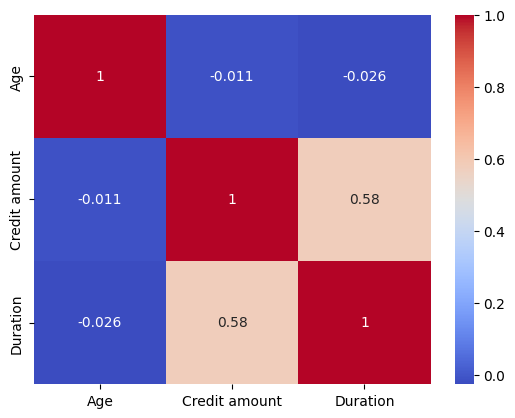

In [1099]:
germanCreditDataNumColsData = germanCreditData.drop(catCols, axis=1)
sns.heatmap(germanCreditDataNumColsData.corr(), annot=True, cmap='coolwarm')

- From the correlation plot, we can see the duration and credit amount is correlation but the value is only 0.58. so we don't need to remove it.

### Perform one-hot encoding for categorical variables:::

In [1100]:
# Encoding our Label
label_encoder = LabelEncoder()
germanCreditData["Risk"] = label_encoder.fit_transform(germanCreditData["Risk"])
target = germanCreditData["Risk"]
germanCreditData.drop(["Risk"], axis=1, inplace=True)
catCols.pop()
catCols

['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Job']

In [1101]:
# One hot enocding other catgorical features:
encoder = OneHotEncoder()
germanCreditDataEncoded = pd.DataFrame(encoder.fit_transform(germanCreditData[catCols]).toarray(), columns=encoder.get_feature_names_out(catCols))
germanCreditData = pd.concat([germanCreditData, germanCreditDataEncoded], axis=1).drop(columns=catCols)

In [1102]:
germanCreditData.head()

,Age,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Saving accounts_Unknown,Saving accounts_little,...,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Job_0,Job_1,Job_2,Job_3
0,67.0,1169.0,6.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,22.0,5951.0,48.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,49.0,2096.0,12.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,45.0,7882.0,42.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,53.0,4870.0,24.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Visualize the histograms of numerical features::

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Credit amount'}>],
       [<Axes: title={'center': 'Duration'}>, <Axes: >]], dtype=object)

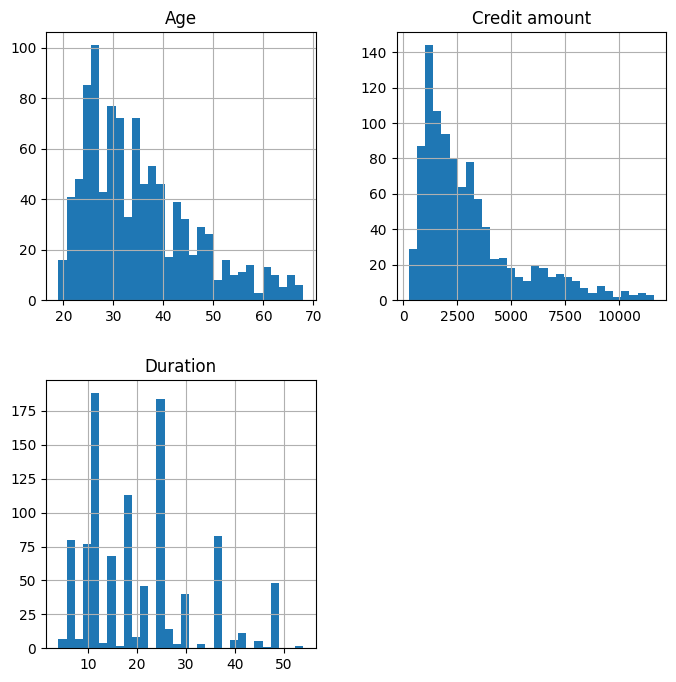

In [1103]:
# Visualize the histograms of numerical features
germanCreditData[numCols].hist(bins=30, figsize=(8, 8))

### Apply log transformation, if applicable, based on the distribution of data:::

- From the histogram, we can see that the features follows normal distribution, there is some skewness. so we can use log transformation to fix it.

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Credit amount'}>],
       [<Axes: title={'center': 'Duration'}>, <Axes: >]], dtype=object)

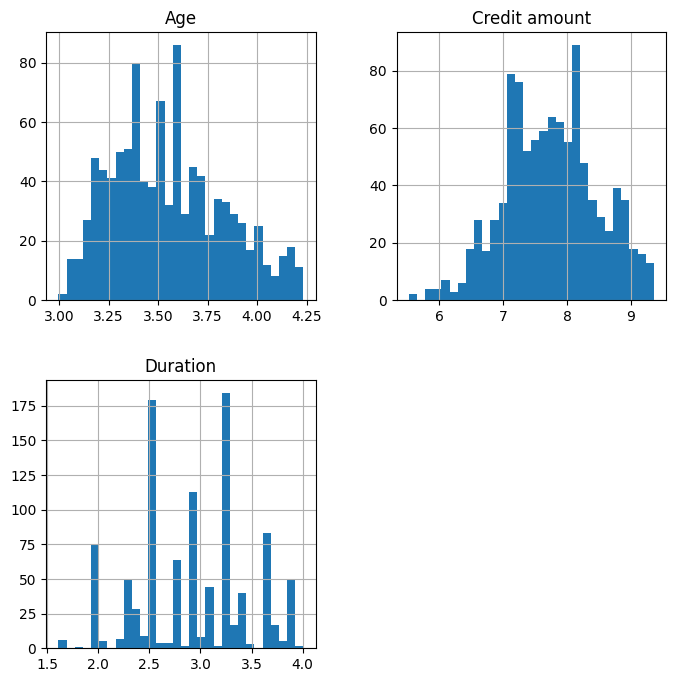

In [1104]:
# to prevent the 0 converted to null values, adding small value to each feature
small_constant = 1e-8

for feature in numCols:
    if germanCreditData[feature].skew() > 0.6:
        germanCreditData[feature] = np.log1p(germanCreditData[feature]) + small_constant
germanCreditData[numCols].hist(bins=30, figsize=(8, 8))

- We can see the histogram is shifted a bit, after the log transformation.

### Apply Feature Scaling:::

In [1105]:
scaler = StandardScaler()
germanCreditData[numCols] = scaler.fit_transform(germanCreditData[numCols])
numericalFeatures = germanCreditData[numCols]

### Use elbow plot to find the optimum number of clusters::

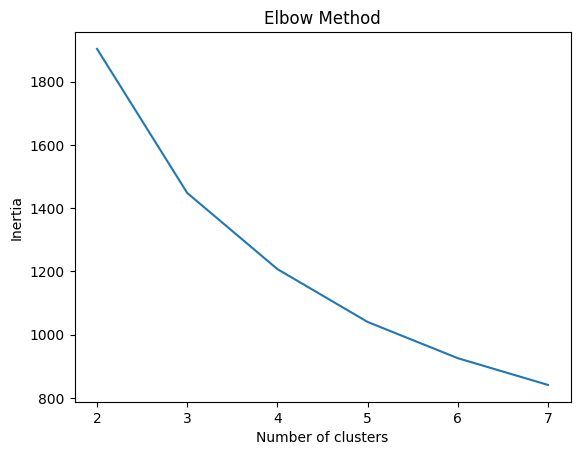

In [1106]:
# Apply elbow method to find best number of clusters
inertia = []
for i in range(2, 8):
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=0).fit(numericalFeatures)
    inertia.append(kmeans.inertia_)
plt.plot(range(2, 8), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

- We can see the break at 3, so the optimal number of clusters will be 3.

### Implement KMeans Clustering and PCA::

In [1107]:
# Applying the kmeans using optimal no. of clusters::
optimalClus = 3
kmeans = KMeans(n_clusters=optimalClus, n_init=10, random_state=42)
clusters = kmeans.fit_predict(numericalFeatures)
numericalFeatures['Cluster'] = clusters

cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_), 
    columns=numericalFeatures.columns[:-1]
)
print("Cluster Centers:")
print(cluster_centers)


Cluster Centers:
        Age  Credit amount  Duration
0  3.314527       7.299509  2.633848
1  3.839636       7.366972  2.610360
2  3.521904       8.401726  3.393830


In [1108]:
# Applying PCA using 2 components
pca = PCA(n_components=2)
data_pca = pca.fit_transform(numericalFeatures)

### Visualize the clusters in the data using PCA:::

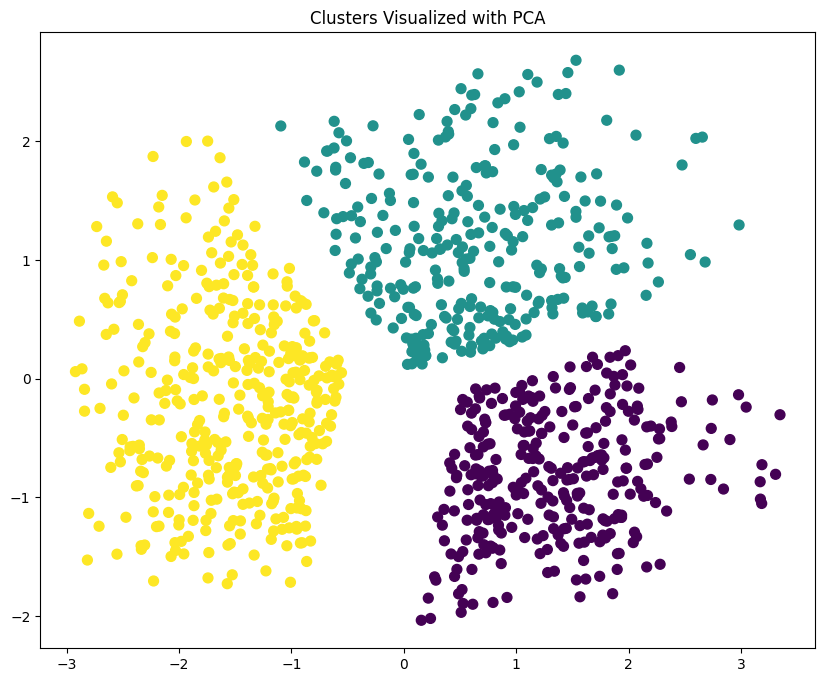

In [1109]:
plt.figure(figsize=(10, 8))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=clusters, cmap='viridis', s=50)
plt.title('Clusters Visualized with PCA')
plt.show()

- We can see the distribution of numerical dataframes in 2 components PCA as above. We can see the classification into 4 clusters, and the classification of clusters is pretty clear.

### Implement KFOLD CV using any classifier of your choosing and report the evaluation metrics(precision, recall, and accuracy)::

In [1110]:
features = germanCreditData

rf_classifier = RandomForestClassifier(random_state=42)

n_splits = 5

accuracy_scores = cross_val_score(rf_classifier, features, target, cv=n_splits)

for i, accuracy in enumerate(accuracy_scores, 1):
    print(f'Fold {i}: Accuracy = {accuracy}')

predictions = cross_val_predict(rf_classifier, features, target, cv=n_splits)

accuracy = accuracy_score(target, predictions)
print(f'Overall Accuracy: {accuracy}\n')

precision = precision_score(target, predictions, average=None)
recall = recall_score(target, predictions, average=None)

for i, (prec, rec) in enumerate(zip(precision, recall), 1):
    print(f'Class {i}: Precision = {prec}, Recall = {rec}\n')

mean_precision = precision.mean()
mean_recall = recall.mean()
print(f'Mean Precision across all classes: {mean_precision}')
print(f'Mean Recall across all classes: {mean_recall}')


Fold 1: Accuracy = 0.675
Fold 2: Accuracy = 0.755
Fold 3: Accuracy = 0.725
Fold 4: Accuracy = 0.755
Fold 5: Accuracy = 0.775
Overall Accuracy: 0.737

Class 1: Precision = 0.5807860262008734, Recall = 0.44333333333333336

Class 2: Precision = 0.7833981841763943, Recall = 0.8628571428571429

Mean Precision across all classes: 0.6820921051886338
Mean Recall across all classes: 0.6530952380952382


In [1111]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

rf_classifier.fit(X_train, y_train)
predictions = rf_classifier.predict(X_test)

feature_importances = rf_classifier.feature_importances_
sorted_idx = feature_importances.argsort()

accuracy = rf_classifier.score(X_test, y_test)
print(f'Accuracy on the test set: {accuracy}')
print(classification_report(y_test, predictions))


Accuracy on the test set: 0.71
              precision    recall  f1-score   support

           0       0.51      0.34      0.41        59
           1       0.76      0.87      0.81       141

    accuracy                           0.71       200
   macro avg       0.64      0.60      0.61       200
weighted avg       0.69      0.71      0.69       200



### Conclusion

- As we applied the kfold cv to the full features, the average accuracy shown by it was 0.737 with the average precision and recall 0.68 and 0.65 respectively. The Precision and recall for the first class is 0.58 and 0.44 whilst for second class is 0.78 and 0.86.
- The final classification using Random forest classifier shows accuracy of 0.71 only. the classification report shows the result is quite well towards 2nd class while the first class has f1-score less than half.